<a href="https://www.kaggle.com/code/m000sey/fantasy-baseball-eda?scriptVersionId=151183741" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import warnings
from xgboost import XGBRegressor
import seaborn as sb

# Ignore all future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
print("libraries uploaded...")

# Import the data
data = pd.read_csv('/kaggle/input/sandlot-fantasy-baseball-league-data/fantasy_data.csv')
print("data imported...")

# reorder columns
new_order = ['index', 'team', 'R', 'HR', 'RBI', 'SB', 'AVG', 'OBP', 'K', 'QS', 'W',
             'SV', 'ERA', 'WHIP', 'league_size', 'MOVES', 'bye', 'playoffs', 'win_percentage',
             'year', 'ring_count', 'draft_position','regular_rank', 'final_rank',]

data = data.reindex(columns=new_order)
print("data columns reorganized")

# Print the total number of NaN values
print("Pre-feature engineering NaN Values:", data.isna().sum().sum())

libraries uploaded...
data imported...
data columns reorganized
Pre-feature engineering NaN Values: 0


In [2]:
# Data cleaning and curating 

# Modify some columns
data.drop(['index'], axis=1, inplace=True)
# data.drop(['team'], axis=1, inplace=True)
data.rename(columns={'MOVES': 'moves'}, inplace=True)

# Define a dictionary to map the values
rank_mapping_12 = {12: 1, 11: 2, 10: 3, 9: 4, 8: 5, 7: 6, 6: 7, 5: 8, 4: 9, 3: 10, 2: 11, 1: 12}
rank_mapping_10 = {10: 1, 9: 2, 8: 3, 7: 4, 6: 5, 5: 6, 4: 7, 3: 8, 2: 9, 1: 10}
rank_mapping_8  = {8: 1, 7: 2, 6: 3, 5: 4, 4: 5, 3: 6, 2: 7, 1: 8}

def remap_ranks(row):
    league_size = row['league_size']
    if league_size == 12:
        mapped_regular_reg_rank   = rank_mapping_12.get(row['regular_rank'])
        mapped_regular_final_rank = rank_mapping_12.get(row['final_rank'])
    elif league_size == 10:
        mapped_regular_reg_rank   = rank_mapping_10.get(row['regular_rank'])
        mapped_regular_final_rank = rank_mapping_10.get(row['final_rank'])
    elif league_size == 8:
        mapped_regular_reg_rank   = rank_mapping_8.get(row['regular_rank'])
        mapped_regular_final_rank = rank_mapping_8.get(row['final_rank'])
    else:
        mapped_regular_reg_rank   = row['regular_rank']
        mapped_regular_final_rank = row['final_rank']
    
    return pd.Series({
        'regular_rank': mapped_regular_reg_rank,
        'final_rank': mapped_regular_final_rank,  
    })

data[['regular_rank', 'final_rank']] = data.apply(remap_ranks, axis=1)

# Reverse the direction of ERA and WHIP so greater is better
data['ERA'] = 1 - data['ERA']
data['WHIP'] = 1 - data['WHIP']

# map bools to values
data['playoffs'] = data['playoffs'].map({False: 0, True: 1})
data['bye'] = data['bye'].map({False: 0, True: 1})

In [3]:
def replace_bye_column(row):
    league_size = row['league_size']
    
    if league_size == 12:
        row.loc['bye'] = (row['regular_rank'] == 12) | (row['regular_rank'] == 11)
    elif league_size == 10:
        row.loc['bye'] = (row['regular_rank'] == 10) | (row['regular_rank'] == 9)
    elif league_size == 8:
        row.loc['bye'] = (row['regular_rank'] == 8) | (row['regular_rank'] == 7)
    return row

data = data.apply(replace_bye_column, axis=1)

groups = data.groupby('year')
scaler = MinMaxScaler()

# Create an empty list to store DataFrames for each group (year)
standardized_data_list = []

# Define the columns to standardize
COL = ['R', 'HR', 'RBI', 'SB', 'AVG', 'OBP', 
       'K', 'QS', 'W', 'SV', 'ERA', 'WHIP', 
       'moves', 'draft_position', 'regular_rank', 'final_rank']

# Create a StandardScaler
scaler = MinMaxScaler()

# Iterate through each group (year) and standardize the data within that group
standardized_data_list = []
for year, group_df in groups:
    # Select the columns you want to standardize
    group_df[COL] = scaler.fit_transform(group_df[COL])
    
    # Append the standardized data for the current year to the list
    standardized_data_list.append(group_df)

# Concatenate all DataFrames in the list along rows to create the final standardized DataFrame
data = pd.concat(standardized_data_list, ignore_index=True)

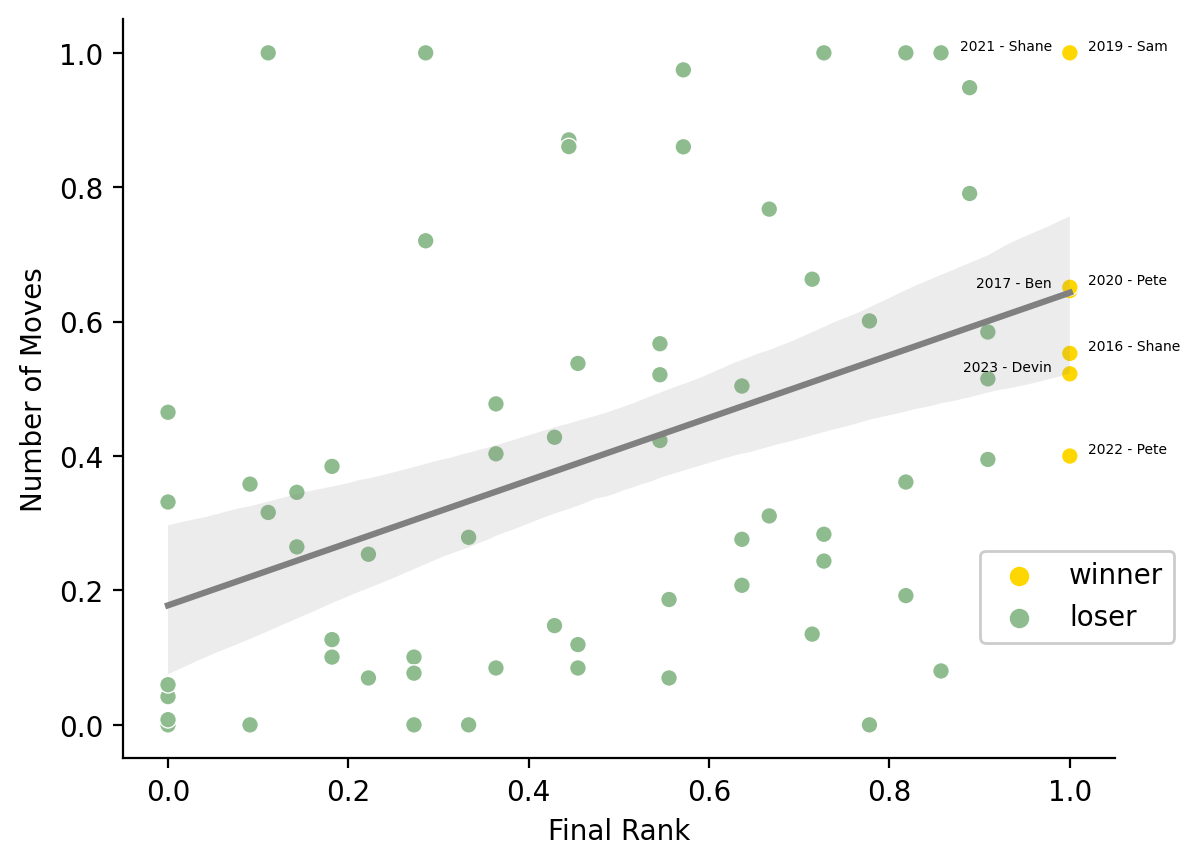

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

data['hue_color'] = np.where(np.isclose(data['final_rank'], 1, atol=1e-9), 'winner', 'loser')
filtered_data = data[data['year'] != 2018]
winners = filtered_data.query('hue_color == "winner"')
winners = winners.sort_values(by='moves')
custom_palette = {'winner': 'gold', 'loser': 'darkseagreen'}
plt.figure(dpi=200)
sns.scatterplot(x='final_rank', y='moves', hue='hue_color', palette=custom_palette, data=filtered_data)
plt.title(None)
for i, (index, row) in enumerate(winners.iterrows()):
    text = f"{row['year']} - {row['team']}"
    
    # Stagger every other label
    if i % 2 == 0:
        plt.text(row['final_rank'] + 0.02, row['moves'], text, fontsize=5, ha='left', va='bottom')
    else:
        plt.text(row['final_rank'] - 0.02, row['moves'], text, fontsize=5, ha='right', va='bottom')

sns.regplot(x='final_rank', y='moves', data=filtered_data, scatter=False, color='grey', ci=95)

plt.xlabel('Final Rank')
plt.ylabel('Number of Moves')
legend = plt.legend(bbox_to_anchor=(0.85, .3), loc='upper left')
legend.get_frame().set_facecolor('white')  # Set legend box color
legend.get_frame().set_alpha(1)  # Set legend box transparency
sns.despine(right=True, top=True)
plt.show()

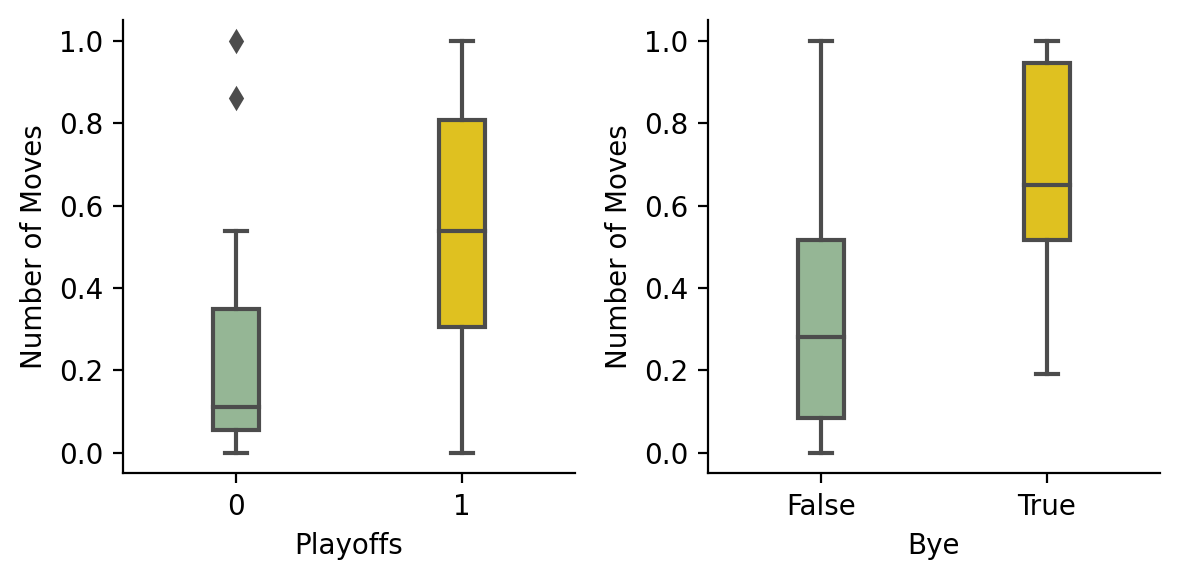

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

filtered_data = data[data['year'] != 2018]

custom_palette = {True: 'gold', False: 'darkseagreen'}
fig = plt.figure(figsize=(6, 3), dpi=200)

# Create a 1x2 grid (1 row, 2 columns)
gs = GridSpec(1, 2, width_ratios=[1, 1])

# Boxplot for 'playoffs'
ax0 = plt.subplot(gs[0])
sns.boxplot(x='playoffs', y='moves', palette=custom_palette, data=filtered_data, width=0.2, ax=ax0)
ax0.set_xlabel('Playoffs')
ax0.set_ylabel('Number of Moves')
ax0.set_title(None)
sns.despine(right=True, top=True)

# Boxplot for 'bye'
ax1 = plt.subplot(gs[1])
sns.boxplot(x='bye', y='moves', palette=custom_palette, data=filtered_data, width=0.2, ax=ax1)
ax1.set_xlabel('Bye')
ax1.set_ylabel('Number of Moves')
ax1.set_title(None)
sns.despine(right=True, top=True)

plt.tight_layout()
plt.show()

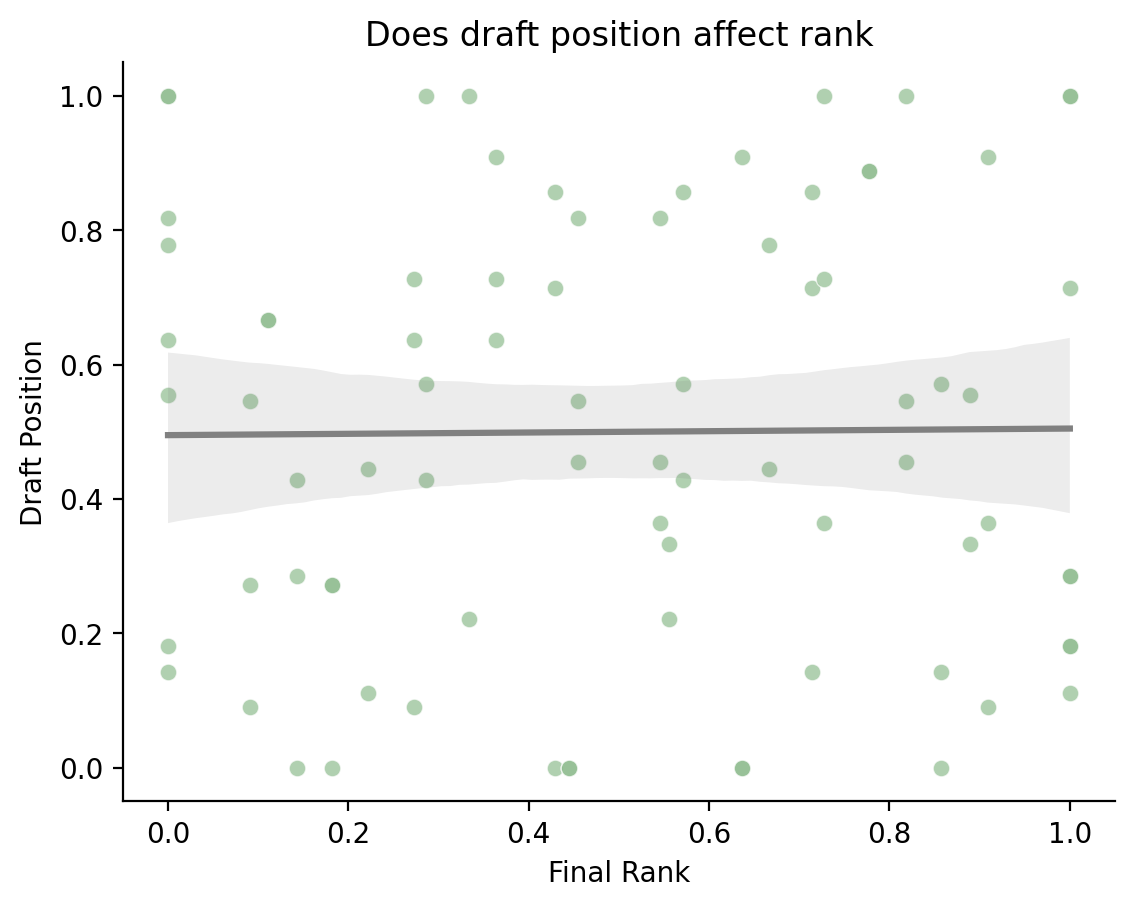

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(dpi=200)
sns.scatterplot(x='final_rank', y='draft_position', data=data, alpha=0.7, color='darkseagreen')
sns.regplot(x='final_rank', y='draft_position', data=data, scatter=False, color='grey', ci=95)
plt.xlabel('Final Rank')
plt.ylabel('Draft Position')
plt.title('Does draft position affect rank')
sns.despine(right=True, top=True)
plt.show()

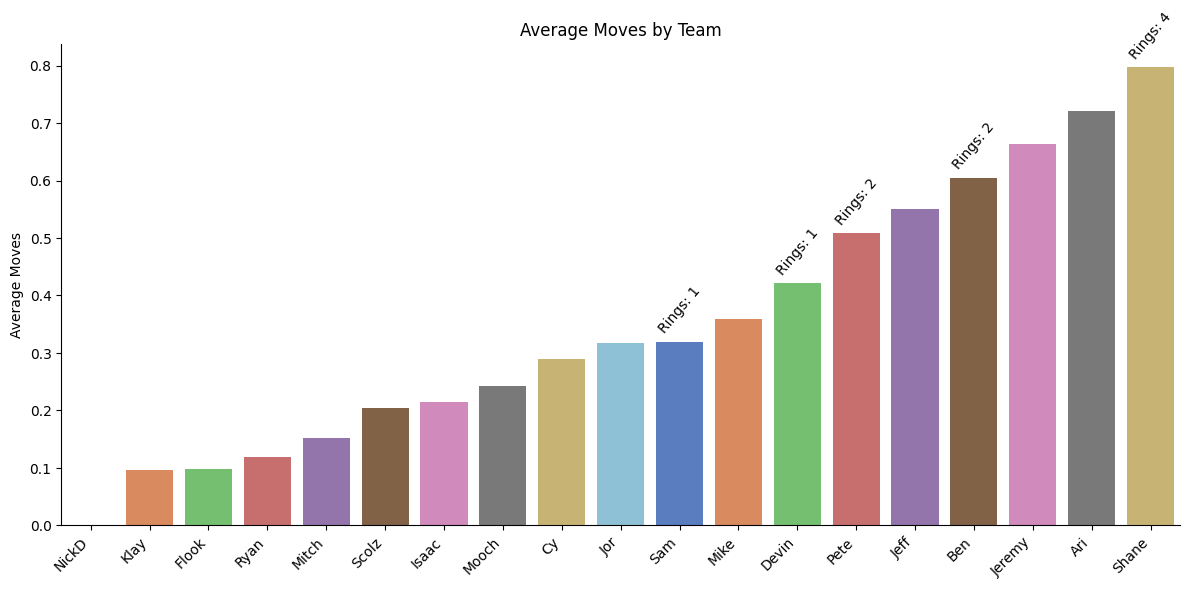

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the ring counts dictionary
ring_counts = {
    'Shane': 4,
    'Ben': 2,
    'Pete': 2,
    'Sam': 1,
    'Devin': 1
}

unique_teams = data['team'].unique()
team_data_dict = {}

for team in unique_teams:
    team_data = data[data['team'] == team]
    team_count = len(team_data)
    total_moves = team_data['moves'].sum()
    average_moves = total_moves / team_count
    
    # Check if the team is in the ring_counts dictionary
    if team in ring_counts:
        rings_label = f'Rings: {ring_counts[team]}'
    else:
        rings_label = ''
    
    team_data_dict[team] = {'average_moves': average_moves, 'rings_label': rings_label}

sorted_teams = sorted(team_data_dict, key=lambda x: team_data_dict[x]['average_moves'])

plt.figure(figsize=(12, 6))
sns.barplot(x=sorted_teams, y=[team_data_dict[team]['average_moves'] for team in sorted_teams], palette='muted')
plt.xlabel('')
plt.ylabel('Average Moves')
plt.title('Average Moves by Team')

# Label the rings above each bar for teams with rings
for team in sorted_teams:
    rings_label = team_data_dict[team]['rings_label']
    if rings_label:
        plt.text(sorted_teams.index(team), team_data_dict[team]['average_moves'] + 0.01, rings_label,
                 ha='center', va='bottom', rotation=50)

sns.despine(right=True, top=True)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

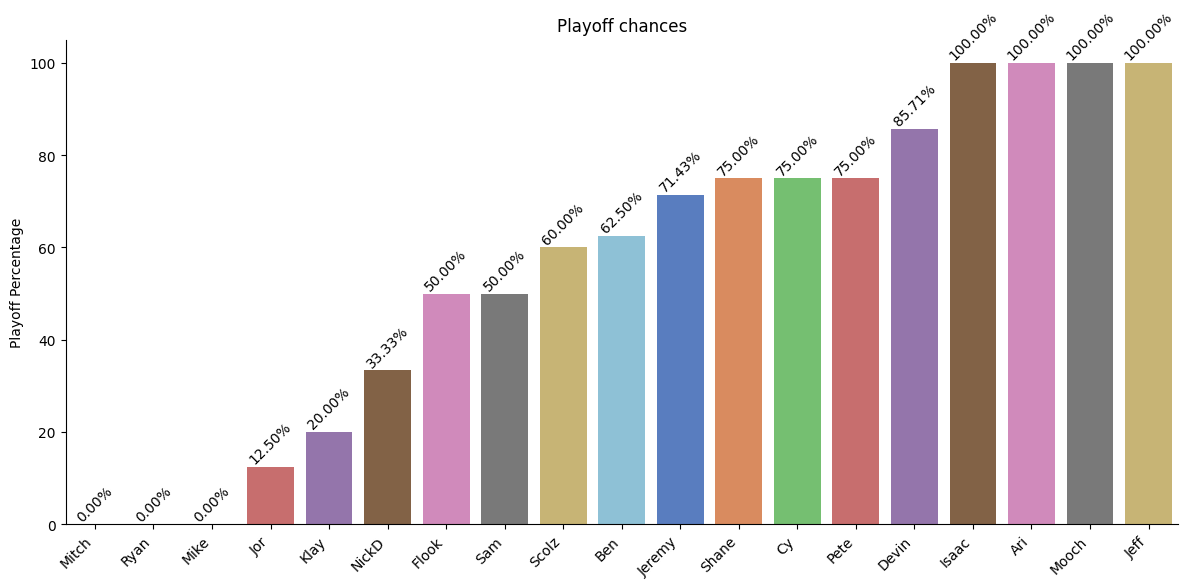

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

unique_teams = data['team'].unique()
team_data_dict = {}

for team in unique_teams:
    team_data = data[data['team'] == team]
    team_count = len(team_data)
    
    # Count the number of playoff appearances
    playoff_count = team_data['playoffs'].sum()
    
    # Calculate playoff percentage
    playoff_percentage = (playoff_count / team_count) * 100
    
    team_data_dict[team] = {'playoff_percentage': playoff_percentage}

sorted_teams = sorted(team_data_dict, key=lambda x: team_data_dict[x]['playoff_percentage'])

plt.figure(figsize=(12, 6))
sns.barplot(x=sorted_teams, y=[team_data_dict[team]['playoff_percentage'] for team in sorted_teams], palette='muted')
plt.xlabel('')
plt.ylabel('Playoff Percentage')
plt.title('Playoff chances')

# Label the playoff percentage above each bar
for team in sorted_teams:
    plt.text(sorted_teams.index(team), team_data_dict[team]['playoff_percentage'] + 0.1, f"{team_data_dict[team]['playoff_percentage']:.2f}%",
             ha='center', va='bottom', rotation=45)
sns.despine(right=True, top=True)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

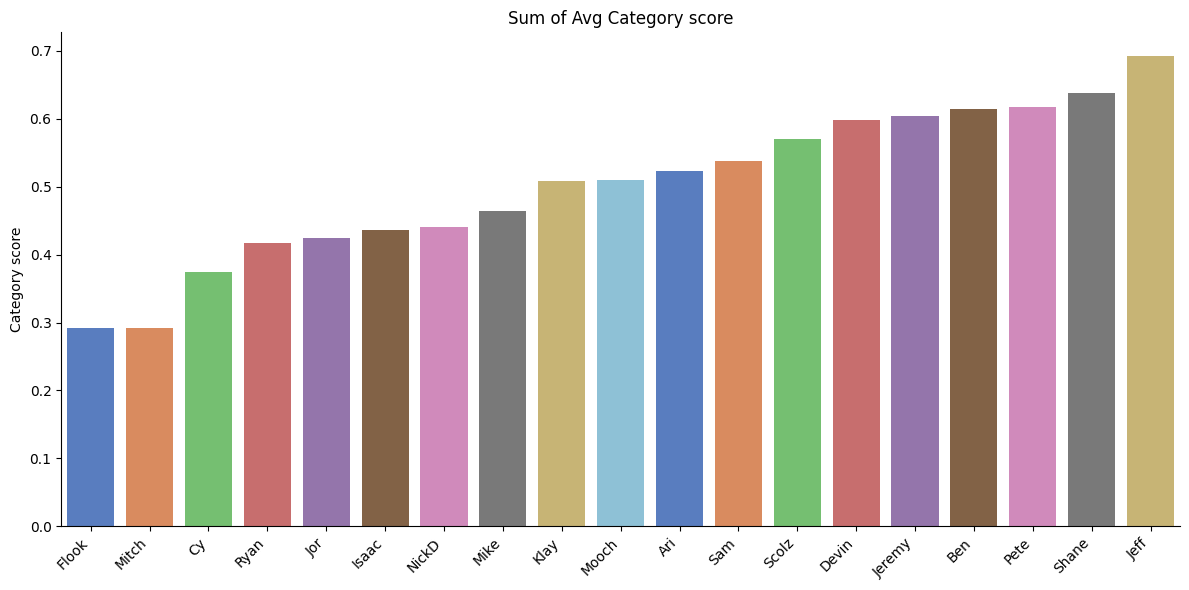

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'data' DataFrame is already defined
col_cat = ['R', 'HR', 'RBI', 'SB', 'AVG', 'OBP', 'K', 'QS', 'W', 'SV', 'ERA', 'WHIP']

data['sum'] = data[col_cat].sum(axis=1) / 12

average_sum_per_team = data.groupby('team')['sum'].mean().reset_index()

sorted_teams = average_sum_per_team.sort_values(by='sum', ascending=True)

plt.figure(figsize=(12, 6))
sns.barplot(x='team', y='sum', data=sorted_teams, palette='muted')
plt.xlabel('')
plt.ylabel('Category score')
plt.title('Sum of Avg Category score')
plt.xticks(rotation=45, ha='right')
sns.despine(right=True, top=True)
plt.tight_layout()
plt.show()

In [10]:
col_cat = ['R', 'HR', 'RBI', 'SB', 'AVG', 'OBP', 'K', 'QS', 'W', 'SV', 'ERA', 'WHIP']

unique_teams = data['team'].unique()

top_columns_dict = {}

for team in unique_teams:
    team_data = data[data['team'] == team]
    
    # Calculate the sum for each category
    for category in col_cat:
        category_sum_col = f'{category}_sum'
        data.loc[data['team'] == team, category_sum_col] = team_data[category].sum() / len(team_data)
    
    # Get the top 3 columns based on sum (without _sum)
    top_columns = data.columns[data.columns.str.endswith('_sum')].to_list()
    top_columns.sort(key=lambda x: data.loc[data['team'] == team, x].iloc[0], reverse=True)
    top_columns = [col[:-4] for col in top_columns[:3]]  # Remove the _sum part
    top_columns_dict[team] = top_columns

# Display the top 3 columns for each team
for team, top_columns in top_columns_dict.items():
    print(f"{team}: {', '.join(top_columns)}")

Shane: K, QS, HR
Cy: OBP, AVG, RBI
Flook: SV, AVG, SB
Ben: K, QS, W
Devin: SB, AVG, R
Jeremy: HR, ERA, WHIP
Mitch: AVG, OBP, SV
Jor: SV, WHIP, QS
Isaac: SV, RBI, ERA
Ari: HR, RBI, QS
Sam: OBP, ERA, K
Klay: WHIP, HR, RBI
Scolz: RBI, AVG, K
NickD: R, WHIP, ERA
Pete: W, R, QS
Mooch: R, RBI, ERA
Jeff: QS, K, W
Ryan: RBI, ERA, WHIP
Mike: ERA, OBP, RBI


In [11]:
hitting_cat = ['R_sum', 'HR_sum', 'RBI_sum', 'SB_sum', 'AVG_sum', 'OBP_sum']
pitching_cat = ['K_sum', 'QS_sum', 'W_sum', 'SV_sum', 'ERA_sum', 'WHIP_sum']

data['hitting'] = data[hitting_cat].sum(axis=1)
data['pitching'] = data[pitching_cat].sum(axis=1)

unique_teams = data['team'].unique()

for team in unique_teams:
    team_data = data[data['team'] == team]
    hitting_sum = team_data['hitting'].iloc[0].round(2)
    pitching_sum = team_data['pitching'].iloc[0].round(2)
    print(f"{team}: Hitting - {hitting_sum}, Pitching - {pitching_sum}")

Shane: Hitting - 3.6, Pitching - 4.05
Cy: Hitting - 2.77, Pitching - 1.71
Flook: Hitting - 1.88, Pitching - 1.63
Ben: Hitting - 3.25, Pitching - 4.13
Devin: Hitting - 3.81, Pitching - 3.37
Jeremy: Hitting - 3.72, Pitching - 3.54
Mitch: Hitting - 2.22, Pitching - 1.28
Jor: Hitting - 2.13, Pitching - 2.97
Isaac: Hitting - 2.01, Pitching - 3.23
Ari: Hitting - 3.26, Pitching - 3.01
Sam: Hitting - 3.15, Pitching - 3.3
Klay: Hitting - 3.25, Pitching - 2.85
Scolz: Hitting - 3.73, Pitching - 3.12
NickD: Hitting - 3.09, Pitching - 2.19
Pete: Hitting - 3.57, Pitching - 3.85
Mooch: Hitting - 3.31, Pitching - 2.81
Jeff: Hitting - 4.02, Pitching - 4.3
Ryan: Hitting - 2.19, Pitching - 2.81
Mike: Hitting - 2.93, Pitching - 2.64


In [12]:
hitting_cat = ['R_sum', 'HR_sum', 'RBI_sum', 'SB_sum', 'AVG_sum', 'OBP_sum']
pitching_cat = ['K_sum', 'QS_sum', 'W_sum', 'SV_sum', 'ERA_sum', 'WHIP_sum']

# Create new columns 'hitting' and 'pitching'
data['hitting'] = data[hitting_cat].sum(axis=1)
data['pitching'] = data[pitching_cat].sum(axis=1)

# Create a new column 'toss_tee'
data['toss_tee'] = data.apply(lambda row: 'toss' if row['pitching'] > row['hitting'] else 'tee', axis=1)

# Get the unique teams
unique_teams = data['team'].unique()

# Print each team and their first associated 'toss_tee' value
for team in unique_teams:
    team_data = data[data['team'] == team]
    first_toss_tee = team_data['toss_tee'].iloc[0]
    print(f"{team}: {first_toss_tee}")

Shane: toss
Cy: tee
Flook: tee
Ben: toss
Devin: tee
Jeremy: tee
Mitch: tee
Jor: toss
Isaac: toss
Ari: tee
Sam: toss
Klay: tee
Scolz: tee
NickD: tee
Pete: toss
Mooch: tee
Jeff: toss
Ryan: toss
Mike: tee
